In [1]:
#特徴量全使用+全ダミー化+pdaysは-1とそれ以外で分ける
#特徴量16
#スコア：0.9335632

In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [3]:
#データ読込
df=pd.read_csv("/content/bank_train.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27128 entries, 0 to 27127
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         27128 non-null  int64 
 1   age        27128 non-null  int64 
 2   job        27128 non-null  object
 3   marital    27128 non-null  object
 4   education  27128 non-null  object
 5   default    27128 non-null  object
 6   balance    27128 non-null  int64 
 7   housing    27128 non-null  object
 8   loan       27128 non-null  object
 9   contact    27128 non-null  object
 10  day        27128 non-null  int64 
 11  month      27128 non-null  object
 12  duration   27128 non-null  int64 
 13  campaign   27128 non-null  int64 
 14  pdays      27128 non-null  int64 
 15  previous   27128 non-null  int64 
 16  poutcome   27128 non-null  object
 17  y          27128 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 3.7+ MB


In [5]:
#使用col
use_cols = ["id",
    "age",
    'job',
    'marital',
    'education',
    'default',
    "balance",
    "housing",
    "loan",
    "contact",
    "day",
    "month",
    "duration",
    "campaign",
    'pdays',
    'previous',
    "poutcome",
    "y"
]

In [6]:
df_use = df[use_cols]

In [7]:
def data_pre(df):

    #pdaysは-1とそれ以外で分ける
    df.loc[df['pdays']>=0, 'pdays'] = 1
    df.loc[df['pdays']>=0, 'pdays'] = 0

    #IDカテゴリー化
    df["id"]=df["id"].astype("category")

    #job列のダミー変数化
    dummies_job=pd.get_dummies(df["job"], dtype=int,drop_first=True,prefix="job")
    df = pd.concat([df, dummies_job], axis=1)
    df.drop(columns=['job'], inplace=True)

    #marital列のダミー変数化
    dummies_marital=pd.get_dummies(df["marital"], dtype=int,drop_first=True,prefix="marital")
    df = pd.concat([df, dummies_marital], axis=1)
    df.drop(columns=['marital'], inplace=True)

    #education列のダミー変数化
    dummies_education=pd.get_dummies(df["education"], dtype=int,drop_first=True,prefix="education")
    df = pd.concat([df, dummies_education], axis=1)
    df.drop(columns=['education'], inplace=True)

    #default列のダミー変数化
    dummies_default=pd.get_dummies(df["default"], dtype=int,drop_first=True,prefix="default")
    df = pd.concat([df, dummies_default], axis=1)
    df.drop(columns=['default'], inplace=True)

    #housing列のダミー変数化
    dummies_housing=pd.get_dummies(df["housing"], dtype=int,drop_first=True,prefix="housing")
    df = pd.concat([df, dummies_housing], axis=1)
    df.drop(columns=['housing'], inplace=True)

    #loan列のダミー変数化
    dummies_loan=pd.get_dummies(df["loan"], dtype=int,drop_first=True,prefix="loan")
    df = pd.concat([df, dummies_loan], axis=1)
    df.drop(columns=['loan'], inplace=True)

    #contact列のダミー変数化
    dummies_contact=pd.get_dummies(df["contact"], dtype=int,drop_first=True,prefix="contact")
    df = pd.concat([df, dummies_contact], axis=1)
    df.drop(columns=['contact'], inplace=True)

    #month列の数値化
    dic={"jan":1,"feb":2,"mar":3,"apr":4,"may":5,"jun":6,"jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12}
    df["month"]=df["month"].map(dic).astype(int)

    #poutcome列のダミー変数化
    dummies_poutcome=pd.get_dummies(df["poutcome"], dtype=int,drop_first=True,prefix="poutcome")
    df = pd.concat([df, dummies_poutcome], axis=1)
    df.drop(columns=['poutcome'], inplace=True)

    return df

In [8]:
df_use = data_pre(df_use)

In [9]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae


df_train,df_val =train_test_split(df_use,test_size=0.2,random_state=42)

col = "y"
train_y = df_train[col]
train_x = df_train.drop(col,axis=1)

val_y = df_val[col]
val_x =df_val.drop(col,axis=1)

trains = lgb.Dataset(train_x,train_y)
valids = lgb.Dataset(val_x,val_y)

params = {
    'objective': 'binary',      # 二値分類
    'metric': 'binary_logloss',                # 評価指標：（ロジスティック損失）
    'num_leaves': 31,               # 葉の数
    'learning_rate': 0.1,          # 学習率
    'feature_fraction': 1.0,        # 特徴量のサブサンプル率
    'bagging_fraction': 1.0,        # バギングのサブサンプル率
    'bagging_freq': 5,              # バギングの頻度
    'max_depth': -1,                # ツリーの最大深さ（制限なし）
    'min_data_in_leaf': 1        # 葉の最小データ数
}

model = lgb.train(
    params,
    trains,
    valid_sets=valids,
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=100)])

[LightGBM] [Info] Number of positive: 2565, number of negative: 19137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.205163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 747
[LightGBM] [Info] Number of data points in the train set: 21702, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118192 -> initscore=-2.009665
[LightGBM] [Info] Start training from score -2.009665
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.188883


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# モデルの予測
pred_y = model.predict(val_x, num_iteration=model.best_iteration)

# 平均二乗誤差（MSE）や平均絶対誤差（MAE）の計算
mse = mean_squared_error(val_y, pred_y)
mae = mean_absolute_error(val_y, pred_y)
print(f'MSE: {mse}, MAE: {mae}')

MSE: 0.0594672881391892, MAE: 0.12026502366137685


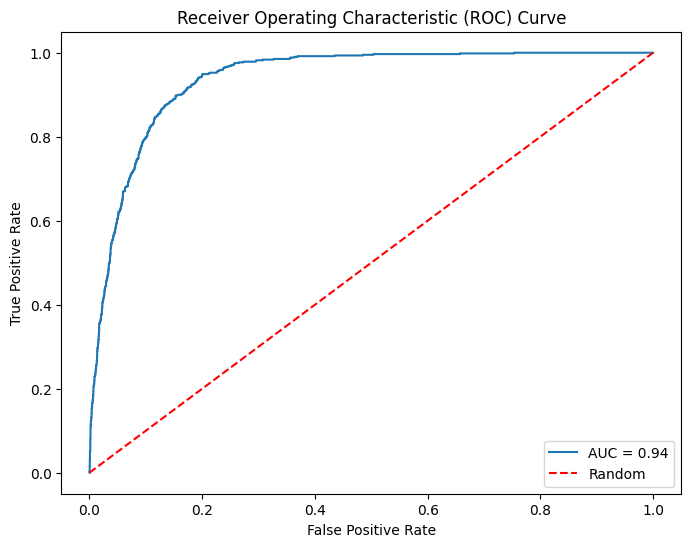

In [11]:
# 予測値から確率に変換する関数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# モデルの予測値を確率に変換
pred_probs = sigmoid(pred_y)
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ROC曲線とAUCの計算
fpr, tpr, thresholds = roc_curve(val_y, pred_probs)
auc = roc_auc_score(val_y, pred_probs)

# ROC曲線のプロット
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [17]:
print(auc)

0.9374998508634411


In [12]:
#データ読み込み
df_test=pd.read_csv("/content/bank_test.csv")

In [13]:
df_test = data_pre(df_test)

In [14]:
predict = model.predict(df_test)
df_test["y"]=predict

df_ID=df_test["id"]
df_test["id"]=df_ID.astype(int)
df_test.to_csv("sample_submit.csv",columns=['id', 'y'],index = False,header = False)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

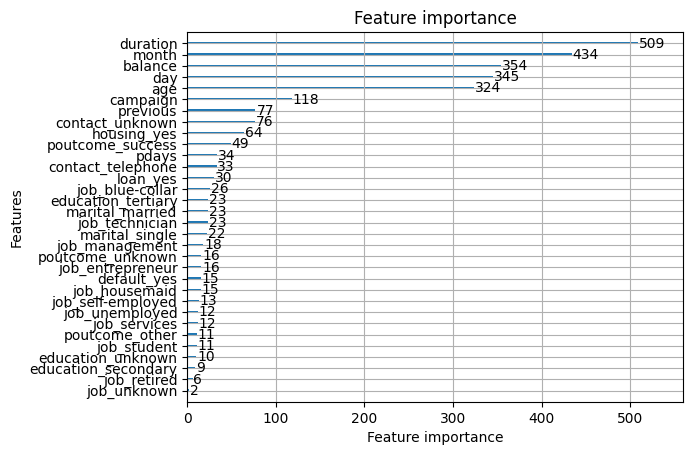

In [15]:
lgb.plot_importance(model)

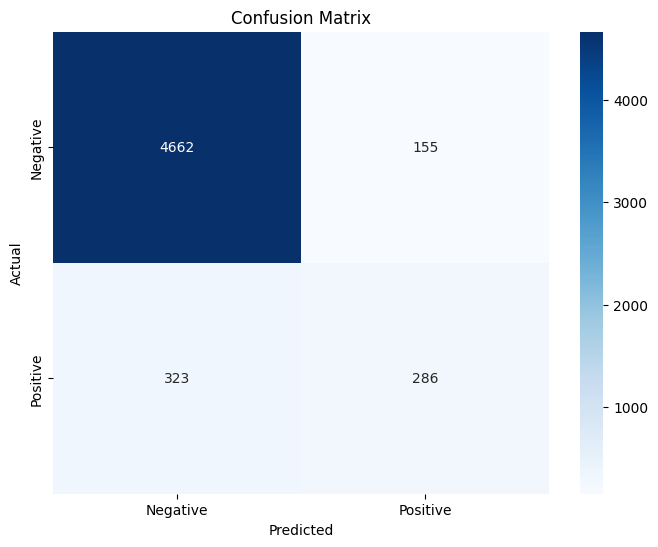

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
# 予測（確率）
predict_prob = model.predict(val_x)
# 予測（クラス）
threshold = 0.5
predict_class = (predict_prob >= threshold).astype(int)
# 混同行列
conf_matrix = confusion_matrix(val_y, predict_class)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
# 評価指標
accuracy = accuracy_score(val_y, predict_class)
precision = precision_score(val_y, predict_class)
recall = recall_score(val_y, predict_class)
f1 = f1_score(val_y, predict_class)
roc_auc = roc_auc_score(val_y, predict_prob)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

Accuracy: 0.91
Precision: 0.65
Recall: 0.47
F1 Score: 0.54
ROC AUC: 0.94
